## EU solar generation using
---
30 years EU solar generation data download [here](https://www.kaggle.com/sohier/30-years-of-european-solar-generation/downloads/30-years-of-european-solar-generation.zip/2)
---

In [29]:
import tensorflow as tf
import tensorboard

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('darkgrid')

### load raw data

In [30]:
# rawdatafilepath=
solarcountry =pd.read_csv('./dataset/EMHIRESPV_TSh_CF_Country_19862015.csv')
solarcountry.head(5)

,AT,BE,BG,CH,CY,CZ,DE,DK,EE,ES,...,LV,NL,NO,PL,PT,RO,SI,SK,SE,UK
0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
solarcountry.shape

(262968, 29)

re time lable
show generation curve of someday(2015-12-01) among all country

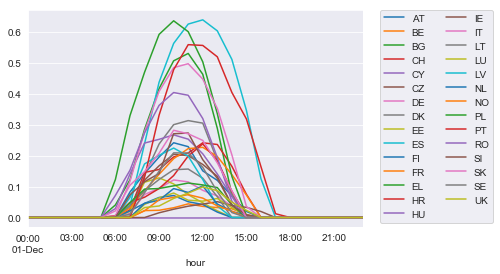

In [32]:
t=pd.date_range('1/1/1986',periods=262968,freq='H')
solarcountry['hour']=t
solarcountry.set_index('hour',inplace=True)
solarcountry['2015-12-01'].plot()
plt.legend(bbox_to_anchor=(1.05,1),loc=2,ncol=2,borderaxespad=0)

show generation curve of somemonth(2015-12) among all

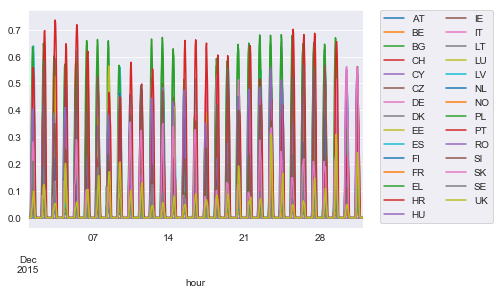

In [33]:
solarcountry['2015-12'].plot()
plt.legend(bbox_to_anchor=(1.05,1),loc=2,ncol=2,borderaxespad=0)

## per DAY

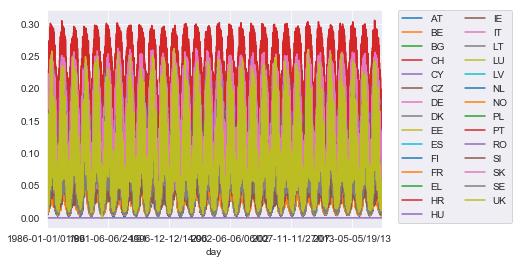

In [34]:
solarcountry['day']=solarcountry.index.map(lambda x:x.strftime('%Y-%m-%D'))
group_day=solarcountry.groupby('day').mean()
group_day.plot()
plt.legend(bbox_to_anchor=(1.05,1),loc=2,ncol=2,borderaxespad=0)

## per MONTH

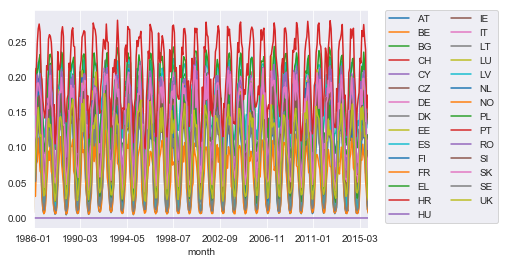

In [35]:
solarcountry['month']=solarcountry.index.map(lambda x:x.strftime('%Y-%m'))
solarcountry['montho']=solarcountry.index.map(lambda x:x.strftime('%m'))
group_month=solarcountry.groupby('month').mean()
group_month.plot()
plt.legend(bbox_to_anchor=(1.05,1),loc=2,ncol=2,borderaxespad=0)

## per YEAR

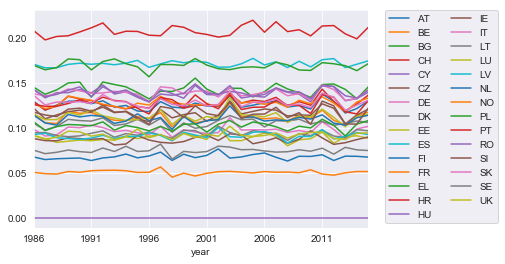

In [36]:
solarcountry['year']=solarcountry.index.map(lambda x:x.strftime('%Y'))
group_year=solarcountry.groupby('year').mean()
group_year.plot()
plt.legend(bbox_to_anchor=(1.05,1),loc=2,ncol=2,borderaxespad=0)

## choose some somecountry
eg:FR

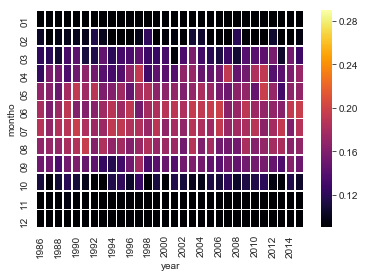

In [37]:
FR_heatmap=solarcountry.pivot_table(index='montho',columns='year',values='FR')
FR_heatmap.sort_index(level=0,ascending=True,inplace=True)
sns.heatmap(FR_heatmap,vmin=0.09,vmax=0.29,cmap='inferno',linewidth=0.5)

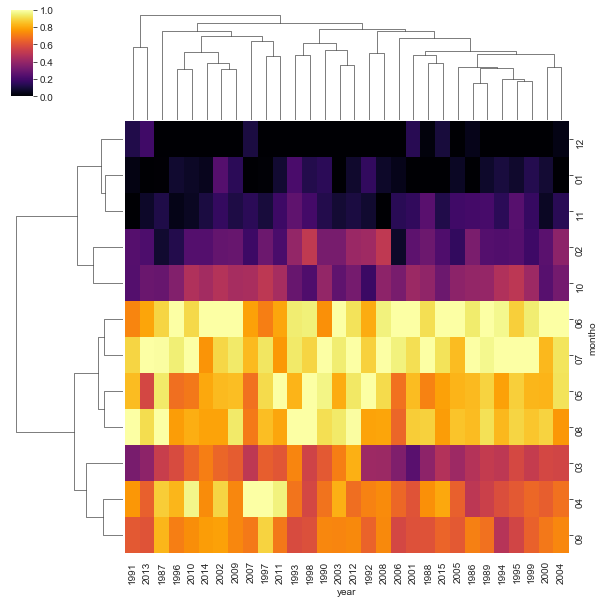

In [38]:
sns.clustermap(FR_heatmap,cmap='inferno',standard_scale=1)

## view from time-series perspective

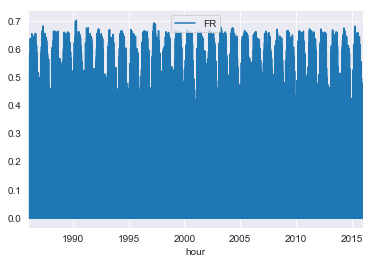

In [39]:
FR_ts_d=solarcountry.filter(['month','year','FR'],axis=1)
FR_ts_d.plot()

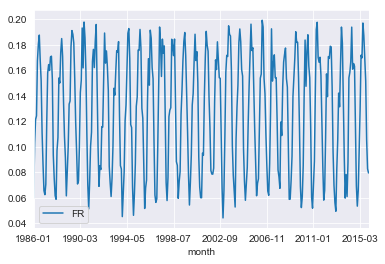

In [40]:
FR_ts_m=FR_ts_d.groupby('month').mean()
FR_ts_m.plot()

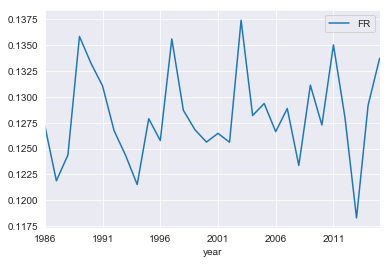

In [41]:
FR_ts_y=FR_ts_d.groupby('year').mean()
FR_ts_y.plot()

# prediction of solar generation

1. first try RNN model to predict next hour's solar generation,


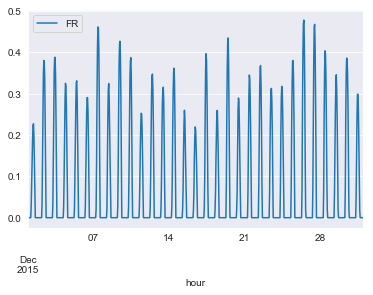

In [42]:
fr_nn=solarcountry.filter(['hour','FR'],axis=1)

fr_nn=fr_nn.reset_index()
fr_nn['hour']=pd.to_datetime(fr_nn['hour'])

start=pd.Timestamp('2015-12-01')
split=pd.Timestamp('2015-12-22')
fr_nn=fr_nn[fr_nn['hour']>=start]

fr_nn=fr_nn.set_index('hour')

fr_nn.plot()

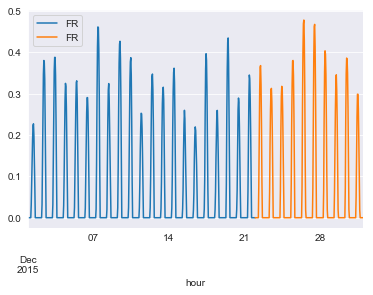

In [43]:
train=fr_nn.loc[:split,['FR']]
test=fr_nn.loc[split:,['FR']]
tr_pl=train
te_pl=test
ax=tr_pl.plot()
te_pl.plot(ax=ax)

train set is up to 22nd December,colored in **blue**, and test set is colored in **orange**

DATA standardscaler 

In [44]:
from sklearn.preprocessing import StandardScaler

sc=StandardScaler()
train_sc=sc.fit_transform(train)
test_sc=sc.transform(test)

# X_train=train_sc[:-1]
# y_train=X_train[1:]
# X_train=X_train[:-1]

# X_test=test_sc[:-1]
# y_test=X_test[1:]
# X_test=X_test[:-1]

### Rolling Windows

In [45]:
train_df=pd.DataFrame(train_sc,columns=['FR'],index=train.index)
test_df=pd.DataFrame(test_sc,columns=['FR'],index=test.index)

for i in range(1,25):
    train_df['shift {}'.format(i)]=train_df['FR'].shift(i,freq='H')
    test_df['shift {}'.format(i)]=test_df['FR'].shift(i,freq='H')

train_df.head(5)

,FR,shift 1,shift 2,shift 3,shift 4,shift 5,shift 6,shift 7,shift 8,shift 9,...,shift 15,shift 16,shift 17,shift 18,shift 19,shift 20,shift 21,shift 22,shift 23,shift 24
hour,,,,,,,,,,,,,,,,,,,,,
2015-12-01 00:00:00,-0.622538,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-01 01:00:00,-0.622538,-0.622538,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-01 02:00:00,-0.622538,-0.622538,-0.622538,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-01 03:00:00,-0.622538,-0.622538,-0.622538,-0.622538,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-01 04:00:00,-0.622538,-0.622538,-0.622538,-0.622538,-0.622538,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


drop NaN

In [46]:
X_train=train_df.dropna().drop('FR',axis=1)
y_train=train_df.dropna()[['FR']]

X_test=test_df.dropna().drop('FR',axis=1)
y_test=test_df.dropna()[['FR']]

X_train.head(5)

,shift 1,shift 2,shift 3,shift 4,shift 5,shift 6,shift 7,shift 8,shift 9,shift 10,...,shift 15,shift 16,shift 17,shift 18,shift 19,shift 20,shift 21,shift 22,shift 23,shift 24
hour,,,,,,,,,,,,,,,,,,,,,
2015-12-02 00:00:00,-0.622538,-0.622538,-0.622538,-0.622538,-0.622538,-0.622538,-0.622538,-0.622538,-0.030582,0.504482,...,0.513964,0.083204,-0.367875,-0.622538,-0.622538,-0.622538,-0.622538,-0.622538,-0.622538,-0.622538
2015-12-02 01:00:00,-0.622538,-0.622538,-0.622538,-0.622538,-0.622538,-0.622538,-0.622538,-0.622538,-0.622538,-0.030582,...,0.924405,0.513964,0.083204,-0.367875,-0.622538,-0.622538,-0.622538,-0.622538,-0.622538,-0.622538
2015-12-02 02:00:00,-0.622538,-0.622538,-0.622538,-0.622538,-0.622538,-0.622538,-0.622538,-0.622538,-0.622538,-0.622538,...,1.189905,0.924405,0.513964,0.083204,-0.367875,-0.622538,-0.622538,-0.622538,-0.622538,-0.622538
2015-12-02 03:00:00,-0.622538,-0.622538,-0.622538,-0.622538,-0.622538,-0.622538,-0.622538,-0.622538,-0.622538,-0.622538,...,1.223769,1.189905,0.924405,0.513964,0.083204,-0.367875,-0.622538,-0.622538,-0.622538,-0.622538
2015-12-02 04:00:00,-0.622538,-0.622538,-0.622538,-0.622538,-0.622538,-0.622538,-0.622538,-0.622538,-0.622538,-0.622538,...,0.982652,1.223769,1.189905,0.924405,0.513964,0.083204,-0.367875,-0.622538,-0.622538,-0.622538


In [47]:
X_train.shape

(481, 24)

to np.array

In [48]:
X_train=X_train.values
y_train=y_train.values

X_test=X_test.values
y_test=y_test.values

## Predictive Model

re-dimension dataset for LSTM layer

In [49]:
X_train_w=X_train.reshape(X_train.shape[0],1,24)
X_test_w=X_test.reshape(X_test.shape[0],1,24)
X_train_w.shape

(481, 1, 24)

In [50]:
from keras.models import Sequential
from keras.layers import Dense,LSTM,Flatten
from keras.optimizers import Adam
import keras.callbacks
import keras.backend as K

In [51]:
K.clear_session()

eps=50
bs=1

in_sh=(1,24)
hidden_1=12
hidden_2=12
outputs=1

model=Sequential()
model.add(LSTM(hidden_1,input_shape=in_sh))
model.add(Dense(hidden_2,activation='relu'))
model.add(Dense(outputs))
model.compile(optimizer='adam',loss='mean_squared_error')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 12)                1776      
_________________________________________________________________
dense_1 (Dense)              (None, 12)                156       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 13        
Total params: 1,945
Trainable params: 1,945
Non-trainable params: 0
_________________________________________________________________


In [52]:
early_stop=keras.callbacks.EarlyStopping(monitor='loss',patience=1,verbose=1)
tbhisto=keras.callbacks.TensorBoard(log_dir='./logs',write_grads=True)
history=model.fit(X_train_w,y_train,epochs=eps,verbose=1,callbacks=[tbhisto])

Epoch 1/50
481/481 [==============================] - 1s 1ms/step - loss: 0.8629
Epoch 2/50
481/481 [==============================] - 0s 237us/step - loss: 0.6603
Epoch 3/50
481/481 [==============================] - 0s 249us/step - loss: 0.4845
Epoch 4/50
481/481 [==============================] - 0s 247us/step - loss: 0.3365
Epoch 5/50
481/481 [==============================] - 0s 249us/step - loss: 0.2240
Epoch 6/50
481/481 [==============================] - 0s 241us/step - loss: 0.1489
Epoch 7/50
481/481 [==============================] - 0s 245us/step - loss: 0.1051
Epoch 8/50
481/481 [==============================] - 0s 241us/step - loss: 0.0865
Epoch 9/50
481/481 [==============================] - 0s 231us/step - loss: 0.0766
Epoch 10/50
481/481 [==============================] - 0s 231us/step - loss: 0.0737
Epoch 11/50
481/481 [==============================] - 0s 241us/step - loss: 0.0707
Epoch 12/50
481/481 [==============================] - 0s 250us/step - loss: 0.0700
Epo

In [53]:
y_pred=model.predict(X_test_w)

y_pred_raw=sc.inverse_transform(y_pred)
y_test_raw=sc.inverse_transform(y_test)

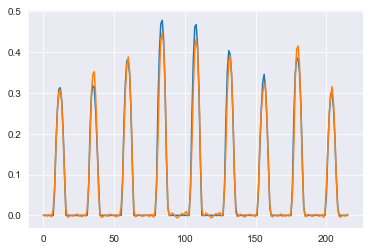

In [54]:
plt.plot(y_test_raw)
plt.plot(y_pred_raw)

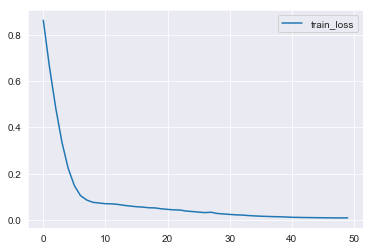

In [55]:
plt.plot(history.epoch,np.array(history.history['loss']),label='train_loss')
plt.legend()

In [56]:
# writer=tf.summary.FileWriter('./logs',tf.get_default_graph())
# writer.close()
